In [1]:
import os, gc, torch, PIL, pickle,json,io

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.constants import DEFAULT_REFLACX_LABEL_COLS

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class RetrainedModels(Enum):
    mobilenet_with_fix = "val_lesion-detection_froc_0_7916_test_lesion-detection_froc_0_8150_epoch15_04-01-2023 03-02-43_lesion_dsetection_with_fix_mobilenet"
    mobilenet_baseline = "val_lesion-detection_froc_0_7764_test_lesion-detection_froc_0_8036_epoch8_04-01-2023 07-46-01_lesion_dsetection_baseline_mobilenet"
    resnet18_with_fix = "val_lesion-detection_froc_0_7982_test_lesion-detection_froc_0_8257_epoch5_04-01-2023 11-24-08_lesion_dsetection_with_fix_resnet18"
    resnet18_baseline = "val_lesion-detection_froc_0_7893_test_lesion-detection_froc_0_8075_epoch5_04-01-2023 13-53-42_lesion_dsetection_baseline_resnet18"
    densenet_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8169_epoch12_04-02-2023 03-08-03_lesion_dsetection_with_fix_densenet"
    densenet_baseline = "val_lesion-detection_froc_0_7841_test_lesion-detection_froc_0_7864_epoch7_04-02-2023 06-38-49_lesion_dsetection_baseline_densenet"
    efficientnet_b5_with_fix = "val_lesion-detection_froc_0_7980_test_lesion-detection_froc_0_8006_epoch7_04-02-2023 19-25-56_lesion_dsetection_with_fix_efficientnet_b5"
    efficientnet_b5_baseline = "val_lesion-detection_froc_0_7846_test_lesion-detection_froc_0_8189_epoch5_04-02-2023 22-14-38_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b0_with_fix = "val_lesion-detection_froc_0_8030_test_lesion-detection_froc_0_8089_epoch7_04-02-2023 12-42-11_lesion_dsetection_with_fix_efficientnet_b0"
    efficientnet_b0_baseline = "val_lesion-detection_froc_0_7939_test_lesion-detection_froc_0_8115_epoch5_04-02-2023 15-17-34_lesion_dsetection_baseline_efficientnet_b0"
    vgg16_with_fix = "val_lesion-detection_froc_0_8004_test_lesion-detection_froc_0_8247_epoch9_04-03-2023 01-53-49_lesion_dsetection_with_fix_vgg16"
    vgg16_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_7991_epoch8_04-03-2023 04-59-07_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix ="val_lesion-detection_froc_0_8059_test_lesion-detection_froc_0_8284_epoch7_04-03-2023 10-01-30_lesion_dsetection_with_fix_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_froc_0_7862_test_lesion-detection_froc_0_8172_epoch5_04-03-2023 14-04-49_lesion_dsetection_baseline_regnet_y_8gf"
    convnext_base_with_fix = "val_lesion-detection_froc_0_8141_test_lesion-detection_froc_0_8278_epoch7_04-03-2023 17-07-24_lesion_dsetection_with_fix_convnext_base"
    convnext_base_baseline = "val_lesion-detection_froc_0_7903_test_lesion-detection_froc_0_8092_epoch11_04-03-2023 21-17-10_lesion_dsetection_baseline_convnext_base"
    resnet50_with_fix = "val_lesion-detection_froc_0_8201_test_lesion-detection_froc_0_8307_epoch7_04-04-2023 01-13-30_lesion_dsetection_with_fix_resnet50"
    resnet50_baseline = "val_lesion-detection_froc_0_7882_test_lesion-detection_froc_0_8111_epoch6_04-04-2023 04-00-17_lesion_dsetection_baseline_resnet50"
    resnet50_with_fix_silent = "val_lesion-detection_froc_0_7947_test_lesion-detection_froc_0_8172_epoch8_04-04-2023 22-46-16_ld_with_fix_resnet50_silent"
    resnet50_with_fix_full = "val_lesion-detection_froc_0_8135_test_lesion-detection_froc_0_8361_epoch10_04-05-2023 04-40-29_ld_with_fix_resnet50_full"
    
class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2472_test_lesion-detection_ap_0_2637_epoch15_03-23-2023 20-20-07_lesion_dsetection_with_fixation_convnext_base_silent_report"
    # convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    convnext_base_with_fix_silent = "val_lesion-detection_ap_0_2405_test_lesion-detection_ap_0_2543_epoch19_03-24-2023 13-57-29_lesion_dsetection_with_fixation_convnext_base_silent_report"
    convnext_base_with_fix_full = "val_lesion-detection_ap_0_2602_test_lesion-detection_ap_0_2499_epoch22_03-24-2023 04-42-21_lesion_dsetection_with_fixation_convnext_base_full_report"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [4]:
naming_map = {
    TrainedModels.mobilenet_baseline: "mobilenet_baseline (ap)",
    TrainedModels.mobilenet_with_fix: "mobilenet_with_fix (ap)",
    TrainedModels.resnet18_baseline: "resnet18_baseline (ap)",
    TrainedModels.resnet18_with_fix: "resnet18_with_fix (ap)",
    TrainedModels.densenet161_baseline: "densenet161_baseline (ap)",
    TrainedModels.densenet161_with_fix: "densenet161_with_fix (ap)",
    TrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (ap)",
    TrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (ap)",
    TrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (ap)",
    TrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (ap)",
    TrainedModels.convnext_base_with_fix: "convnext_base_with_fix (ap)",
    TrainedModels.convnext_base_baseline: "convnext_base_baseline (ap)",
    TrainedModels.convnext_base_with_fix_silent: "convnext_base_with_fix_silent (ap)",
    TrainedModels.convnext_base_with_fix_full:"convnext_base_with_fix_full (ap)",
    TrainedModels.vgg16_with_fix: "vgg16_with_fix (ap)",
    TrainedModels.vgg16_baseline: "vgg16_baseline (ap)",
    TrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (ap)",
    TrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (ap)",
    RetrainedModels.mobilenet_with_fix: "mobilenet_with_fix (froc)",
    RetrainedModels.mobilenet_baseline: "mobilenet_baseline (froc)",
    RetrainedModels.resnet18_with_fix: "resnet18_with_fix (froc)",
    RetrainedModels.resnet18_baseline: "resnet18_baseline (froc)",
    RetrainedModels.densenet_with_fix: "densenet_with_fix (froc)",
    RetrainedModels.densenet_baseline: "densenet_baseline (froc)",
    RetrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix (froc)",
    RetrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline (froc)",
    RetrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix (froc)",
    RetrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline (froc)",
    RetrainedModels.vgg16_with_fix: "vgg16_with_fix (froc)",
    RetrainedModels.vgg16_baseline: "vgg16_baseline (froc)",
    RetrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix (froc)",
    RetrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline (froc)",
    RetrainedModels.convnext_base_with_fix: "convnext_base_with_fix (froc)",
    RetrainedModels.convnext_base_baseline: "convnext_base_baseline (froc)",
    RetrainedModels.resnet50_with_fix: "resnet50_with_fix (froc)",
    RetrainedModels.resnet50_baseline: "resnet50_baseline (froc)",
    RetrainedModels.resnet50_with_fix_silent :"resnet50_with_fix (silent) (froc)",
    RetrainedModels.resnet50_with_fix_full :"resnet50_with_fix (full) (froc)",
}


In [5]:
score_thrs="0.05"

In [6]:
eval_ss = []

for select_model in RetrainedModels:
    model_path = select_model.value
    for l in DEFAULT_REFLACX_LABEL_COLS + ["all"]:
        eval_df = pd.read_csv(
            os.path.join(
                "./eval_results",
                f"{model_path}_{l}_{score_thrs}.csv",
            ),
            index_col=0,
        )
        eval_s = eval_df.iloc[0]
        eval_s["model"] = naming_map[select_model]
        eval_s["lesion"] = l
        eval_s["score_threshold"] = score_thrs
        states = json.loads(eval_s["coco_states"])
        for s in states:
            eval_s[s["p_title_str"]] = s["mean_s"]
        eval_ss.append(eval_s)


In [7]:
eval_df = pd.DataFrame(eval_ss)

In [8]:
eval_df

,num_fps,num_fns,num_tps,coco_states,Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",froc_curve,...,Average Precision (AP) @[ IoBB=0.50:0.95 | area= small | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area=medium | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= large | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= small | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area=medium | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= large | maxDets= 10 ]
0,523,85,114,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.637998,0.828927,0.913009,0.965628,0.836391,"[0.009145728643216082, 0.00969044988083046, 0....",...,-1,-1,0.096080,0.124623,0.352261,0.391457,0.392965,-1,-1,0.391457
0,801,100,177,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.629964,0.790928,0.943100,0.989170,0.838290,"[0.0016425992779783394, 0.0017404327854560117,...",...,-1,-1,0.175258,0.241877,0.424188,0.457762,0.460650,-1,-1,0.457762
0,741,162,175,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.562719,0.790753,0.933595,0.983526,0.817648,"[0.0121513353115727, 0.012875071021192395, 0.0...",...,-1,-1,0.088495,0.157270,0.328783,0.353709,0.355786,-1,-1,0.353709
0,704,151,166,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.574921,0.762527,0.907033,0.979165,0.805911,"[0.0028706624605678234, 0.003041639631364765, ...",...,-1,-1,0.072410,0.129338,0.295268,0.310726,0.310726,-1,-1,0.310726
0,299,297,107,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.576127,0.758986,0.895502,0.982339,0.803238,"[0.007883663366336634, 0.008353215769800018, 0...",...,-1,-1,0.043325,0.098762,0.156436,0.156436,0.156436,-1,-1,0.156436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,764,87,190,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.656318,0.841448,0.930983,0.992780,0.855382,"[0.011498194945848375, 0.012183029498192083, 0...",...,-1,-1,0.191970,0.217690,0.461733,0.498917,0.498917,-1,-1,0.498917
0,842,132,205,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.607319,0.839433,0.944859,0.985785,0.844349,"[0.004050445103857567, 0.004291690340397465, 0...",...,-1,-1,0.108726,0.169139,0.373294,0.408605,0.411869,-1,-1,0.408605
0,294,178,139,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.611987,0.783951,0.920942,0.985669,0.825637,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-1,-1,0.084704,0.171924,0.275394,0.275394,0.275394,-1,-1,0.275394
0,260,269,135,"[{""ap"": 1, ""iouThr"": null, ""areaRng"": ""all"", ""...",0.627158,0.801568,0.919878,0.980910,0.832379,"[0.009009900990099011, 0.009546532308342877, 0...",...,-1,-1,0.067810,0.119307,0.201485,0.201485,0.201485,-1,-1,0.201485


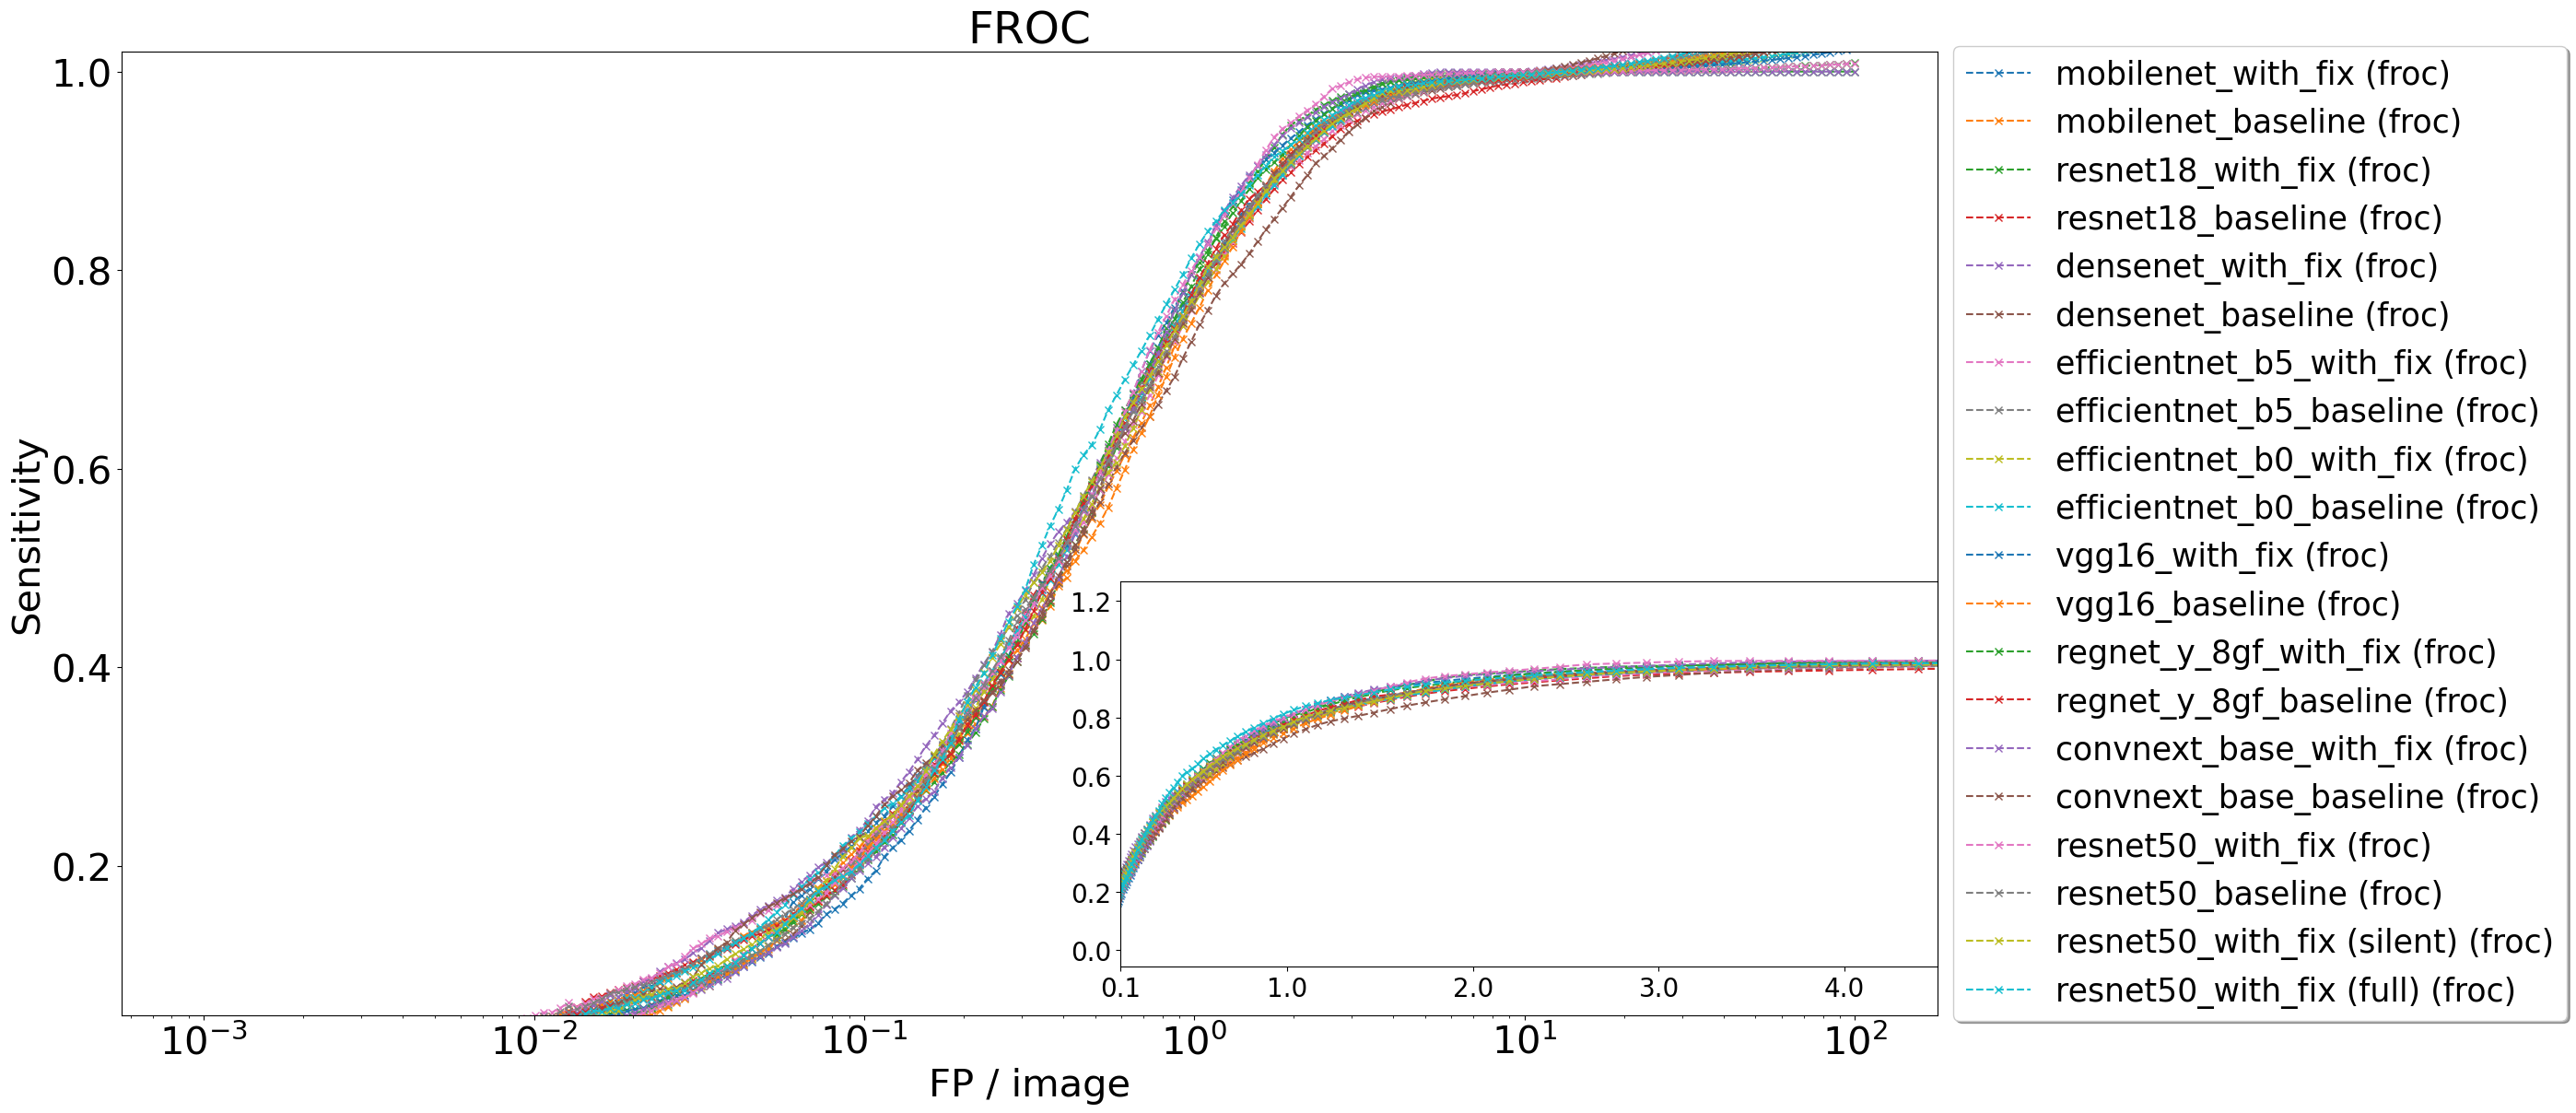

In [9]:
fig, ax = plt.subplots(figsize=[25, 13])

ins = ax.inset_axes([0.55, 0.05, 0.45, 0.4])
ins.set_xticks(
    [0.1, 1.0, 2.0, 3.0, 4.0],
    [
        0.1,
        1.0,
        2.0,
        3.0,
        4.0,
    ],
    fontsize=30,
)

ins.set_xlim([0.1, 4.5])

for idx, eval_instance in eval_df[eval_df["lesion"] == "all"].iterrows():
    froc_curve = json.loads(eval_instance["froc_curve"])
    x_axis = json.loads(eval_instance["x-axis"])
    name = eval_instance["model"]
    ax.semilogx(
        x_axis,
        froc_curve,
        "x--",
        label=name,
    )
    ins.plot(
        x_axis,
        froc_curve,
        "x--",
        label=name,
    )


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(
    loc="center left",
    # bbox_to_anchor=(0.8, 0.6),
    bbox_to_anchor=(1, 0.5),

    fancybox=True,
    shadow=True,
    ncol=1,
    fontsize=25,
)

ax.set_title("FROC", fontdict={"fontsize": 35})
ax.set_ylabel("Sensitivity", fontdict={"fontsize": 30})
ax.set_xlabel("FP / image", fontdict={"fontsize": 30})

ax.tick_params(axis="both", which="major", labelsize=30)
ins.tick_params(axis="both", which="major", labelsize=20)

ax.set_ylim(bottom=0.05, top=1.02)
fig.tight_layout(pad=4.0)
fig.savefig(fname="models_froc.png", dpi=150)

In [10]:
eval_df = eval_df[[
    "model",
    "lesion",
    "num_tps",
    "num_fps",
    "num_fns",
    "Sensitivity@ [avgFP=0.5]",
    "Sensitivity@ [avgFP=1]",
    "Sensitivity@ [avgFP=2]",
    "Sensitivity@ [avgFP=4]",
    "mFROC@[0.5,1,2,4]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets= 30 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets= 30 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=  1 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets=  5 ]",
    " Average Precision  (AP) @[ IoBB=0.50:0.95 | area=   all | maxDets= 10 ]",
    " Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ]",
    " Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets=  1 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets=  5 ]",
    " Average Recall     (AR) @[ IoBB=0.50:0.95 | area=   all | maxDets= 10 ]",
]]


In [11]:
eval_df = eval_df.rename(columns={"num_tps": "#TP @[ IoBB=0.50      | area=   all | maxDets= 30 ]", "num_fps": "#FP @[ IoBB=0.50      | area=   all | maxDets= 30 ]", "num_fns":"#FN @[ IoBB=0.50      | area=   all | maxDets= 30 ]"})

In [12]:
eval_df

,model,lesion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ]
0,mobilenet_with_fix (froc),Pulmonary edema,114,523,85,0.637998,0.828927,0.913009,0.965628,0.836391,0.392965,0.096070,0.034910,0.089129,0.096080,0.184709,0.081697,0.124623,0.352261,0.391457
0,mobilenet_with_fix (froc),Enlarged cardiac silhouette,177,801,100,0.629964,0.790928,0.943100,0.989170,0.838290,0.460650,0.175551,0.126379,0.169913,0.175258,0.293647,0.178582,0.241877,0.424188,0.457762
0,mobilenet_with_fix (froc),Consolidation,175,741,162,0.562719,0.790753,0.933595,0.983526,0.817648,0.355786,0.088562,0.055794,0.084696,0.088495,0.184579,0.069973,0.157270,0.328783,0.353709
0,mobilenet_with_fix (froc),Atelectasis,166,704,151,0.574921,0.762527,0.907033,0.979165,0.805911,0.310726,0.072400,0.038853,0.070542,0.072410,0.191668,0.047004,0.129338,0.295268,0.310726
0,mobilenet_with_fix (froc),Pleural abnormality,107,299,297,0.576127,0.758986,0.895502,0.982339,0.803238,0.156436,0.043325,0.037830,0.043557,0.043325,0.103184,0.026093,0.098762,0.156436,0.156436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,resnet50_with_fix (full) (froc),Enlarged cardiac silhouette,190,764,87,0.656318,0.841448,0.930983,0.992780,0.855382,0.498917,0.191796,0.117977,0.185292,0.191815,0.345311,0.164340,0.217690,0.461733,0.498917
0,resnet50_with_fix (full) (froc),Consolidation,205,842,132,0.607319,0.839433,0.944859,0.985785,0.844349,0.411869,0.109001,0.058613,0.103529,0.108623,0.229828,0.078041,0.169139,0.373294,0.408605
0,resnet50_with_fix (full) (froc),Atelectasis,139,294,178,0.611987,0.783951,0.920942,0.985669,0.825637,0.275394,0.084326,0.057852,0.084326,0.084326,0.185017,0.063702,0.171924,0.275394,0.275394
0,resnet50_with_fix (full) (froc),Pleural abnormality,135,260,269,0.627158,0.801568,0.919878,0.980910,0.832379,0.201485,0.067181,0.055531,0.067561,0.067181,0.147066,0.052263,0.119307,0.201485,0.201485


In [13]:
eval_df.to_csv("rerun-evaluation.csv")

In [14]:
eval_df[eval_df['lesion'] == 'all'].sort_values('mFROC@[0.5,1,2,4]',ascending=False)

,model,lesion,#TP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FP @[ IoBB=0.50 | area= all | maxDets= 30 ],#FN @[ IoBB=0.50 | area= all | maxDets= 30 ],Sensitivity@ [avgFP=0.5],Sensitivity@ [avgFP=1],Sensitivity@ [avgFP=2],Sensitivity@ [avgFP=4],"mFROC@[0.5,1,2,4]",Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 30 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Precision (AP) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.50 | area= all | maxDets= 10 ],Average Precision (AP) @[ IoBB=0.75 | area= all | maxDets= 10 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 1 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 5 ],Average Recall (AR) @[ IoBB=0.50:0.95 | area= all | maxDets= 10 ]
0,resnet50_with_fix (full) (froc),all,809,3570,725,0.630697,0.818102,0.928414,0.984093,0.840326,0.386017,0.108783,0.065199,0.103804,0.108073,0.213844,0.088337,0.159486,0.343485,0.379689
0,resnet50_with_fix (froc),all,685,4057,849,0.585182,0.805888,0.951088,0.994997,0.834289,0.316732,0.079816,0.049567,0.076917,0.079524,0.162740,0.070352,0.132862,0.282984,0.312351
0,convnext_base_with_fix (froc),all,724,5461,810,0.579978,0.802616,0.945346,0.993585,0.830381,0.337260,0.074109,0.043042,0.070033,0.073726,0.154148,0.056615,0.117329,0.285756,0.331395
0,regnet_y_8gf_with_fix (froc),all,747,4255,787,0.592139,0.802093,0.930169,0.991225,0.828907,0.345552,0.086875,0.051301,0.083006,0.086753,0.175285,0.080044,0.137912,0.305444,0.342405
0,vgg16_with_fix (froc),all,790,5394,744,0.581101,0.802498,0.935225,0.984429,0.825813,0.444784,0.113983,0.066545,0.105615,0.112336,0.185514,0.110248,0.161257,0.364096,0.424769
0,resnet18_with_fix (froc),all,804,5513,730,0.565023,0.790098,0.948488,0.990094,0.823426,0.369451,0.089904,0.051849,0.083804,0.089227,0.190978,0.069878,0.132972,0.307877,0.359544
0,regnet_y_8gf_baseline (froc),all,654,5016,880,0.588445,0.782446,0.920522,0.980130,0.817886,0.291303,0.070518,0.044458,0.067336,0.070184,0.147899,0.054661,0.118550,0.251178,0.286083
0,mobilenet_with_fix (froc),all,739,3065,795,0.590680,0.781538,0.917119,0.981009,0.817587,0.333130,0.094836,0.058148,0.091054,0.094749,0.192203,0.081183,0.148790,0.308746,0.332117
0,densenet_with_fix (froc),all,734,3319,800,0.594556,0.775419,0.915888,0.979677,0.816385,0.332327,0.095757,0.058808,0.091579,0.095234,0.193243,0.081868,0.144231,0.296204,0.326290
0,resnet50_with_fix (silent) (froc),all,756,3847,778,0.593870,0.775153,0.911719,0.980047,0.815197,0.365222,0.113117,0.071168,0.110094,0.113136,0.195826,0.102901,0.162773,0.337992,0.364984


In [15]:
# eval_df[eval_df['lesion'] == 'all'].sort_values(' Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 10 ]',ascending=False)